# 4. Image Convolution

## Table of Contents
1. [Libraries](#libraries)
2. [Simple Example](#simple)
3. [PyTorch Convolution](#pytorch)

## Importing Libraries <a class="anchor" id="libraries" ></a>

In [219]:
import matplotlib.pyplot as plt
from io import BytesIO
import numpy as np
from PIL import Image
import requests

## Simple Convolution <a class="anchor" id="simple" ></a>

### Definition

- __I__: Image to convolve.
- __H__: filter matrix to convolve the image with.
- __J__: Result of the convolution.

The following graphics shows exemplary the mathematical operations of the convolution. The filter matrix __H__ is shifted over the input image __I__. The values 'under' the filter matrix are multiplicated with the corresponding values in __H__, summed up and writen to the result __J__. The target position is usually the position under the center of __H__.

<img src="data/convolution.png" width="70%">

In order to implement the convolution with a block filter, we need two methods. The first one will create the block filter matrix __H__ depending on the filter width/height __n__.

A block filter holds the value $\dfrac{1}{n\cdot n}$ at each position:

In [220]:
def block_filter(n):
    H = np.ones((n, n)) / (n * n) # each element in H has the value 1/(n*n)
    return H

We will test the method by creating a filter with ``n = 5``:

In [221]:
H = block_filter(5)
print(H)

[[0.04 0.04 0.04 0.04 0.04]
 [0.04 0.04 0.04 0.04 0.04]
 [0.04 0.04 0.04 0.04 0.04]
 [0.04 0.04 0.04 0.04 0.04]
 [0.04 0.04 0.04 0.04 0.04]]


Next, we define the actual convolution operation. To prevent invalid indices at the border of the image, we introduce the padding __p__.

In [222]:
def apply_filter(I, H):
    h, w = I.shape                         # image dimensions (height, width)
    n = H.shape[0]                         # filter size
    p = n // 2                             # padding size
    J = np.zeros_like(I)                   # output image, initialized with zeros

    for x in range(p, h-p):
        for y in range(p, w-p):
            J[x, y] = np.sum(I[x-p:x+n-p, y-p:y+n-p] * H)
    return J

# Load image function

In [223]:
def load_image(url):
  response =requests.get(url, stream = True)
  response.raise_for_status()

  # Check the content type to verify it's an image
  if "image" in response.headers.get("Content-Type", ""):
      # Open the image using PIL
      image = Image.open(BytesIO(response.content))
      return image
  else:
      print("The URL does not point to a valid image.")

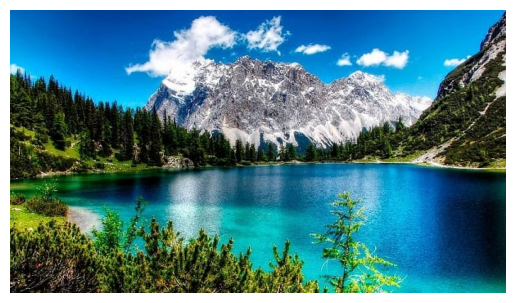

In [224]:
url = "https://raw.githubusercontent.com/hiphobbit/computer_vision/refs/heads/main/data/image.jpg"

image = load_image(url)

# Plot the image using matplotlib
plt.imshow(image)
plt.axis('off')  # Turn off the axis
plt.show()


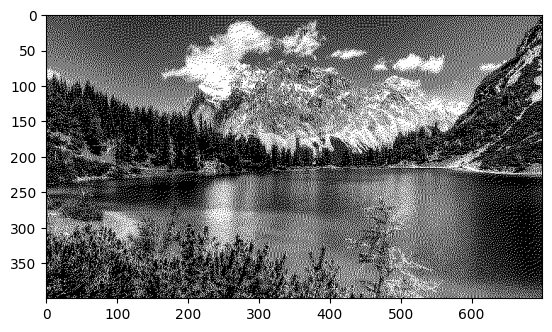

In [225]:
# image = Image.open('data/image.jpg')
image = image.convert('1') # convert image to black and white

image = np.array(image)

# image = np.zeros((200, 200), dtype=np.float)
# for x in range(200):
#     for y in range(200):
#         d = ((x-100)**2+(y-100)**2)**0.5
#         image[x, y] = d % 8 < 4

plt.imshow(image, cmap='gray',vmin=0.0, vmax=1.0)
plt.show()

In [226]:
image = image.astype(float)

Next we test our implementation and apply a block filter with size 7

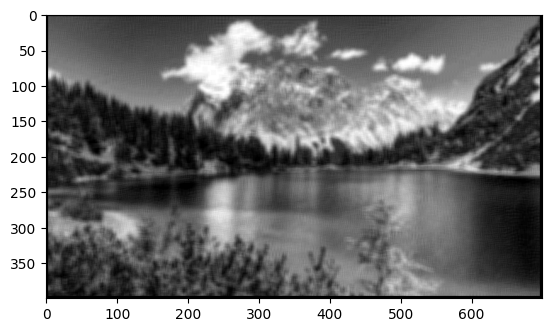

In [227]:
n = 7
H = block_filter(n)
J = apply_filter(image, H)

plt.imshow(J, cmap='gray')
plt.show()

## PyTorch Convolution <a class="anchor" id="pytorch" ></a>

In [228]:
from PIL import Image
response =requests.get(url, stream = True)
img = Image.open(BytesIO(response.content))
img.thumbnail((256,256), Image.Resampling.LANCZOS) # Resize to half to reduce the size of this notebook.

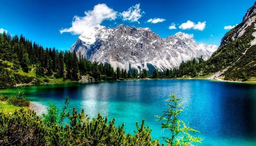

In [229]:
img

In [230]:
import torch, torchvision
from torchvision import transforms
from torch import nn

In [231]:
to_tensor = transforms.Compose([
   transforms.Grayscale(),  # Convert image to grayscale.
   transforms.ToTensor()    # Converts a PIL Image in the range [0, 255] to a torch.FloatTensor in the range [0.0, 1.0].
])

to_pil = transforms.Compose([
    transforms.ToPILImage()
])

In [232]:
input = to_tensor(img)
input.shape


torch.Size([1, 146, 256])

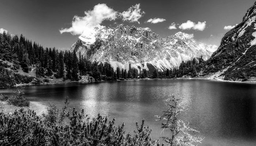

In [233]:
to_pil(input)

2D convolution over an input image:

+ `in_channels = 1`: an input is a grayscale image
+ `out_channels = 1`: an output is a grayscale image
+ `kernel_size = (3, 3)`: the kernel (filter) size is 3 x 3
+ `stride = 1`: the stride for the cross-correlation is 1
+ `padding = 1`: zero-paddings on both sides for 1 point for each dimension
+ `bias = False`: no bias parameter (for simplicity)

In [234]:
conv = nn.Conv2d(1, 1, (3, 3), stride=1, padding=1, bias=False)

In [235]:
# The code below does not work because the convolution layer requires the dimension for batch.
conv(input)

tensor([[[-0.1063, -0.2068, -0.2038,  ..., -0.2813, -0.2948, -0.2344],
         [ 0.0124, -0.1125, -0.1121,  ..., -0.1600, -0.1541, -0.1490],
         [ 0.0098, -0.1181, -0.1160,  ..., -0.1568, -0.1276, -0.0960],
         ...,
         [ 0.0327,  0.0098, -0.0460,  ..., -0.1394, -0.1324, -0.1602],
         [ 0.0281, -0.0313, -0.0600,  ..., -0.1331, -0.1337, -0.1714],
         [-0.0376, -0.0283, -0.0217,  ..., -0.0729, -0.0690, -0.0735]]],
       grad_fn=<SqueezeBackward1>)

We need to insert a dimension for a batch at dim=0.

In [236]:
input = input.unsqueeze(0)
input.shape

torch.Size([1, 1, 146, 256])

In [237]:
output = conv(input)
output.shape

torch.Size([1, 1, 146, 256])

Setting `padding=1` in the convolution layer, we obtain an image of the same size.

In [238]:
output.shape

torch.Size([1, 1, 146, 256])

We need to remove the first dimension before converting to a PIL object.

In [239]:
output.data.squeeze(dim=0).shape

torch.Size([1, 146, 256])

Display the output from the convolution layer by converting `output` to a PIL object.

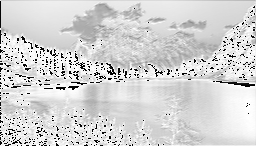

In [240]:
to_pil(output.data.squeeze(dim=0))

Clip every value in the output tensor within the range of [0, 1].

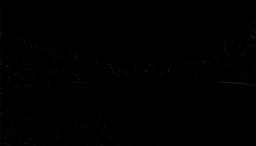

In [241]:
to_pil(torch.clamp(output, 0, 1).data.squeeze(dim=0))

In [242]:
def display(img1, img2):
    im1 = to_pil(torch.clamp(img1, 0, 1).data.squeeze(dim=0))
    im2 = to_pil(torch.clamp(img2, 0, 1).data.squeeze(dim=0))
    dst = Image.new('RGB', (im1.width + im2.width, im1.height))
    dst.paste(im1, (0, 0))
    dst.paste(im2, (im1.width, 0))
    return dst

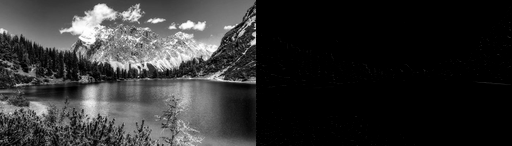

In [243]:
display(input, output)

### Identity

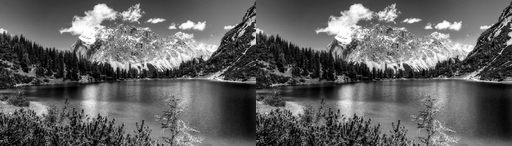

In [244]:
conv.weight.data = torch.tensor([[[
    [0., 0., 0.],
    [0., 1, 0.],
    [0., 0., 0.],
]]])

output = conv(input)
display(input, output)

### Brighten

tensor([[[[0.0000, 0.0000, 0.0000],
          [0.0000, 1.5000, 0.0000],
          [0.0000, 0.0000, 0.0000]]]])


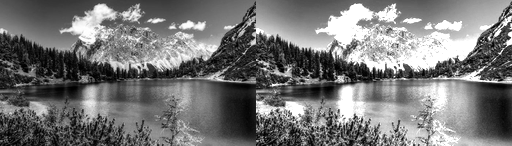

In [245]:
conv.weight.data = torch.tensor([[[
    [0., 0., 0.],
    [0., 1.5, 0.],
    [0., 0., 0.],
]]])
print(conv.weight.data)
output = conv(input)
display(input, output)

### Darken

tensor([[[[0.0000, 0.0000, 0.0000],
          [0.0000, 0.5000, 0.0000],
          [0.0000, 0.0000, 0.0000]]]])


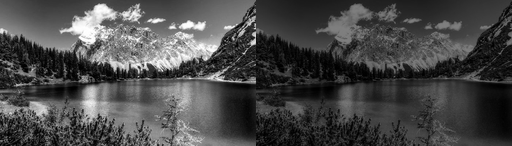

In [246]:
conv.weight.data = torch.tensor([[[
    [0., 0., 0.],
    [0., 0.5, 0.],
    [0., 0., 0.],
]]])
print(conv.weight.data)
output = conv(input)
display(input, output)

### Box blur

tensor([[[[0.1111, 0.1111, 0.1111],
          [0.1111, 0.1111, 0.1111],
          [0.1111, 0.1111, 0.1111]]]])


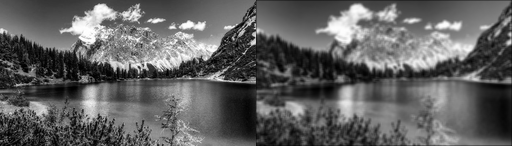

In [247]:
conv.weight.data = torch.ones((1, 1, 3,3), dtype=torch.float) / 9.
print(conv.weight.data)
output = conv(input)
display(input, output)

### Gaussian blur

tensor([[[[0.0625, 0.1250, 0.0625],
          [0.1250, 0.2500, 0.1250],
          [0.0625, 0.1250, 0.0625]]]])


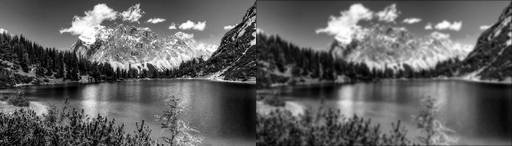

In [248]:
conv.weight.data = torch.tensor([[[
    [1., 2., 1.],
    [2., 4., 2.],
    [1., 2., 1.],
]]])/16.
print(conv.weight.data)
output = conv(input)
display(input, output)

### Sharpen

tensor([[[[ 0., -1.,  0.],
          [-1.,  5., -1.],
          [ 0., -1.,  0.]]]])


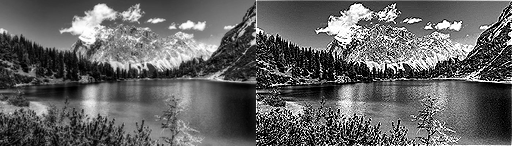

In [249]:
conv.weight.data = torch.tensor([[[
    [0., -1., 0.],
    [-1., 5., -1.],
    [0., -1., 0.],
]]])
print(conv.weight.data)
output = conv(input)
display(input, output)

tensor([[[[ 0., -2.,  0.],
          [-2., 10., -2.],
          [ 0., -2.,  0.]]]])


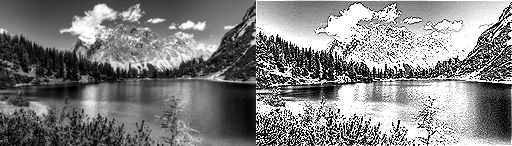

In [250]:
conv.weight.data = torch.tensor([[[
    [0., -2., 0.],
    [-2., 10., -2.],
    [0., -2., 0.],
]]])
print(conv.weight.data)
output = conv(input)
display(input, output)

### Edge detection

tensor([[[[ 0.,  1.,  0.],
          [ 1., -4.,  1.],
          [ 0.,  1.,  0.]]]])


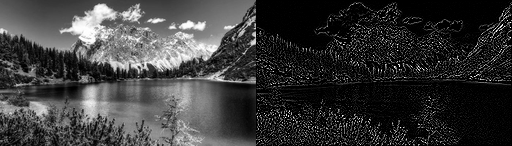

In [251]:
conv.weight.data = torch.tensor([[[
    [0., 1., 0.],
    [1., -4., 1.],
    [0., 1., 0.],
]]])
print(conv.weight.data)
output = conv(input)
display(input, output)

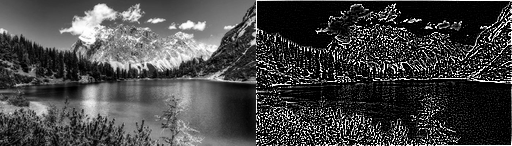

In [252]:
conv.weight.data = torch.tensor([[[
    [-1., -1., -1.],
    [-1., 8., -1.],
    [-1., -1., -1.],
]]])
output = conv(input)
display(input, output)

TODO: Challenge, hard image with hard transformations

1. Implementa los detectores de línea siguientes usando código en Python (es decir, sin usar librerías de OpenCV): Prewitt, Sobel y Laplaciano. Investiga la complejidad algoritmica de estos, ¿cual es más eficiente?

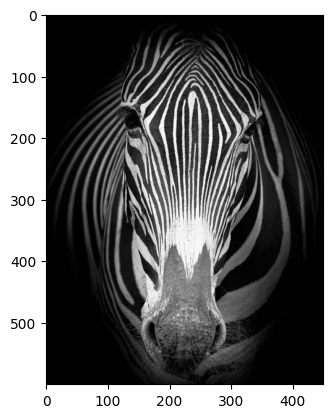

In [253]:
# Load image and convert to grayscale

# add url here
url = "https://savybabyblog.wordpress.com/wp-content/uploads/2018/01/cutting2.jpg"
url = "https://st.depositphotos.com/46146934/60896/i/450/depositphotos_608967356-stock-photo-cebra-parque-natural-cavrceno.jpg"
image_1 = load_image(url)

# Resize image
# new_size = (255, 255)  # Replace with desired dimensions
# image_1 = image_1.resize(new_size)

# convert image to numpy array
image_1 = np.array(image_1)

# convert image to grayscale w/o using opencv
r = image_1[:,:,0]
g = image_1[:,:,1]
b = image_1[:,:,2]

image_1_gray = 0.2989 * r + 0.5870 * g + 0.1140 * b
image_1_gray = image_1_gray.astype(float)
plt.imshow(image_1_gray, cmap = 'gray')
plt.show()

# Applying Prewitt Kernel


Text(0.5, 1.0, 'Prewitt transformation for Edge Detection')

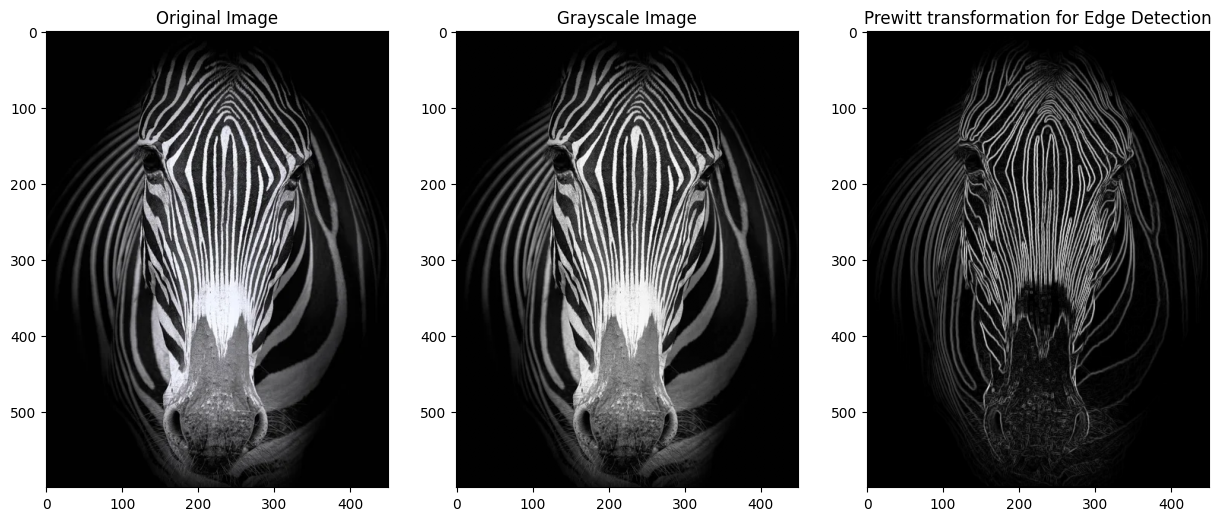

In [254]:
#define horizontal and Vertical sobel kernels
Gx = np.array([[-1, 0, 1],
               [-1, 0, 1],
               [-1, 0, 1]])

Gy = np.array([[-1, -1, -1],
               [0, 0, 0],
               [1, 1, 1]])

# apply filter
pre_x = apply_filter(image_1_gray, Gx)
pre_y = apply_filter(image_1_gray, Gy)

# compute gradiente magnitude
gradient_magnitude = np.sqrt(np.square(pre_x)+ np.square(pre_y))

# normalize
img_prewitt = (gradient_magnitude /np.max(gradient_magnitude) * 255).astype(np.uint8)

# plot images
fig = plt.figure(figsize=(15,10))
plt.subplot(1,3,1)
plt.imshow(image_1)
plt.title('Original Image')
plt.subplot(1,3,2)
plt.imshow(image_1_gray, cmap = 'gray')
plt.title('Grayscale Image')
plt.subplot(1,3,3)
plt.imshow(img_prewitt, cmap = 'gray')
plt.title('Prewitt transformation for Edge Detection')


# Applying Sobel Kernel



Text(0.5, 1.0, 'Sobel transformation for Edge Detection')

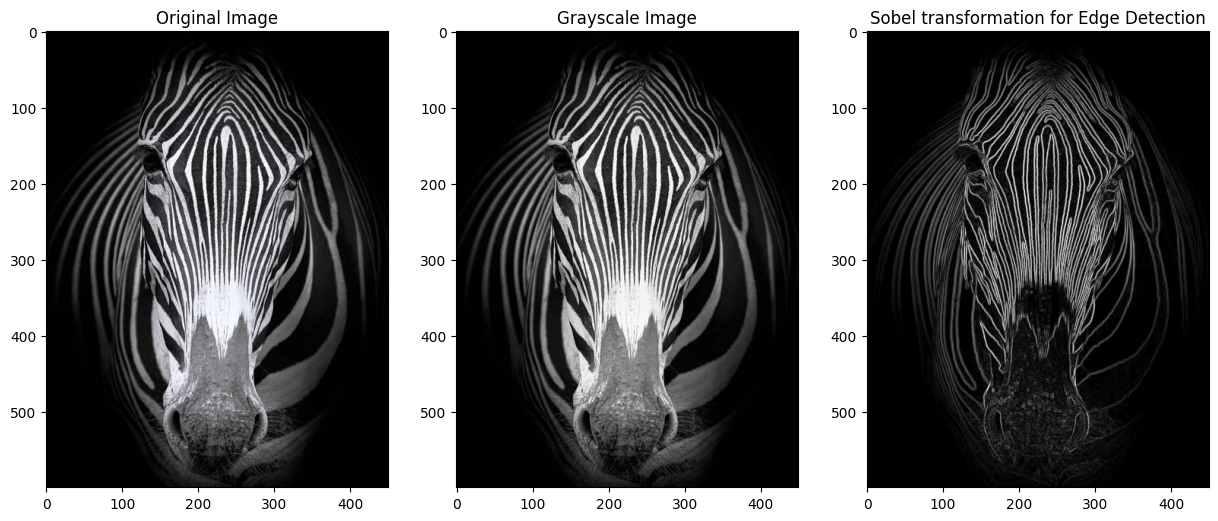

In [255]:
#define horizontal and Vertical sobel kernels
Gx = np.array([[-1, 0, 1],
               [-2, 0, 2],
               [-1, 0, 1]])

Gy = np.array([[-1, -2, -1],
               [0, 0, 0],
               [1, 2, 1]])

# apply filter
pre_x = apply_filter(image_1_gray, Gx)
pre_y = apply_filter(image_1_gray, Gy)

# compute gradiente magnitude
gradient_magnitude = np.sqrt(np.square(pre_x)+ np.square(pre_y))

# normalize
img_sobel = (gradient_magnitude /np.max(gradient_magnitude) * 255).astype(np.uint8)

# plot images
fig = plt.figure(figsize=(15,10))
plt.subplot(1,3,1)
plt.imshow(image_1)
plt.title('Original Image')
plt.subplot(1,3,2)
plt.imshow(image_1_gray, cmap = 'gray')
plt.title('Grayscale Image')
plt.subplot(1,3,3)
plt.imshow(img_sobel, cmap = 'gray')
plt.title('Sobel transformation for Edge Detection')


# Applying Laplacian Kernel

Text(0.5, 1.0, 'Laplacian transformation for Edge Detection')

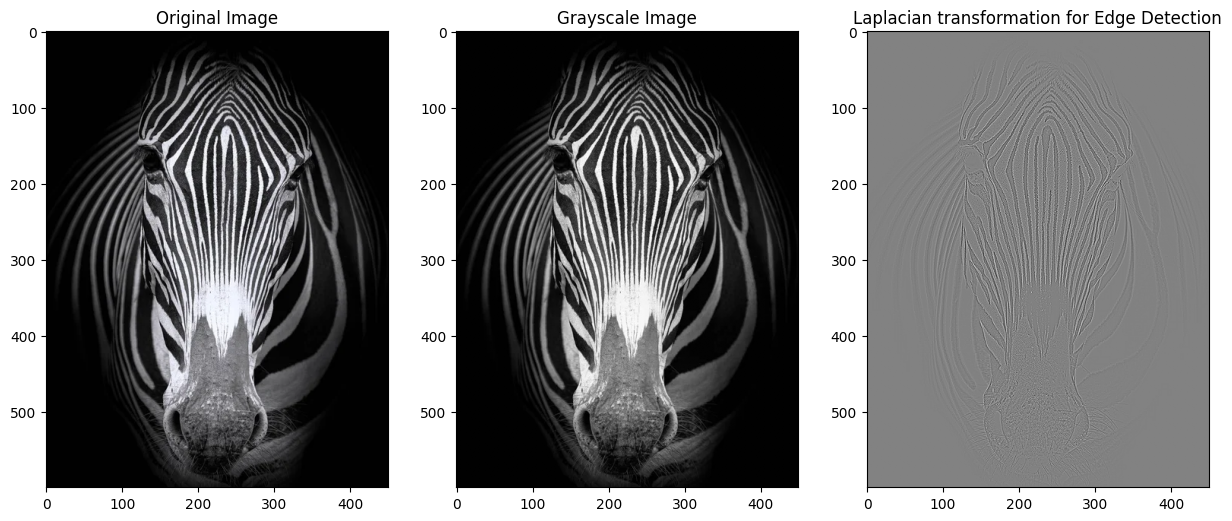

In [256]:
# Define Laplacian kernels (4,8 connected kernels)

laplacian_4_kernel = np.array([
                        [0, 1, 0],
                        [1, -4, 1],
                        [0, 1, 0]])
# apply filter
img_laplacian_4 =  apply_filter(image_1_gray, laplacian_4_kernel)

fig = plt.figure(figsize=(15,10))
plt.subplot(1,3,1)
plt.imshow(image_1)
plt.title('Original Image')
plt.subplot(1,3,2)
plt.imshow(image_1_gray, cmap = 'gray')
plt.title('Grayscale Image')
plt.subplot(1,3,3)
plt.imshow(img_laplacian_4,cmap = 'gray')
plt.title('Laplacian transformation for Edge Detection')

2. Implementa un algoritmos de realce o mejoramiento de imágenes mediante un algoritmo de en el cual se extraen las líneas de la imagen y después se aplica la diferencia con la imagen original, multiplicando los píxeles de la imagen “máscara” (las líneas encontradas) por un factor alfa mayor a 1.

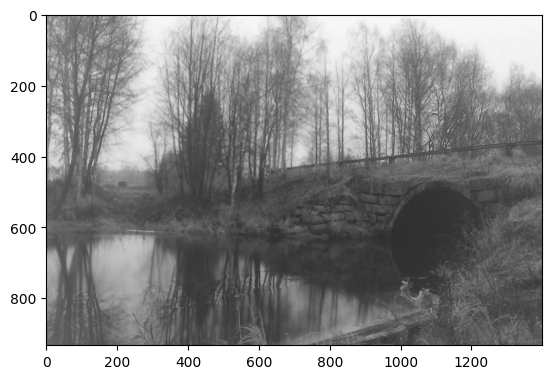

In [257]:
# Load image and convert to grayscale

url = "https://miro.medium.com/v2/resize:fit:1400/format:webp/1*XyOTKWqLq5X9ZT_xemeyTQ.png"
image_1 = load_image(url)

# convert image to numpy array
image_1 = np.array(image_1)

# convert image to grayscale w/o using opencv
r = image_1[:,:,0]
g = image_1[:,:,1]
b = image_1[:,:,2]

image_1_gray = 0.2989 * r + 0.5870 * g + 0.1140 * b
image_1_gray = image_1_gray.astype(float)
plt.imshow(image_1_gray, cmap = 'gray')
plt.show()

a. Extraer líneas mediante algoritmo de Prewitt

Text(0.5, 1.0, 'Prewitt transformation for Edge Detection')

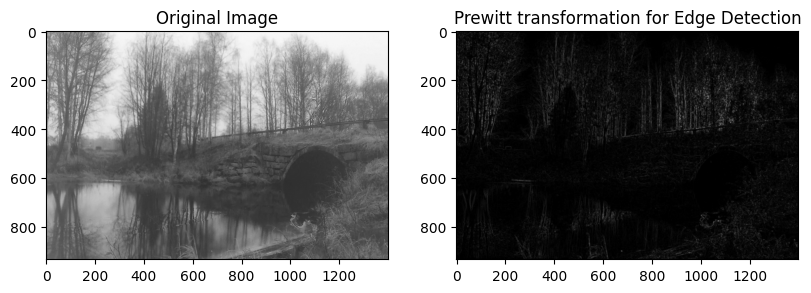

In [258]:
#define horizontal and Vertical sobel kernels
Gx = np.array([[-1, 0, 1],
               [-1, 0, 1],
               [-1, 0, 1]])

Gy = np.array([[-1, -1, -1],
               [0, 0, 0],
               [1, 1, 1]])

# apply filter
pre_x = apply_filter(image_1_gray, Gx)
pre_y = apply_filter(image_1_gray, Gy)

# compute gradiente magnitude
gradient_magnitude = np.sqrt(np.square(pre_x)+ np.square(pre_y))

# normalize
img_prewitt = (gradient_magnitude /np.max(gradient_magnitude) * 255).astype(np.uint8)

# plot images
fig = plt.figure(figsize=(15,10))
plt.subplot(1,3,2)
plt.imshow(image_1_gray, cmap = 'gray')
plt.title('Original Image')
plt.subplot(1,3,3)
plt.imshow(img_prewitt, cmap = 'gray')
plt.title('Prewitt transformation for Edge Detection')

b. Creatar máscara y sumar pixeles de máscara a imagen

Text(0.5, 1.0, 'image_enhanced')

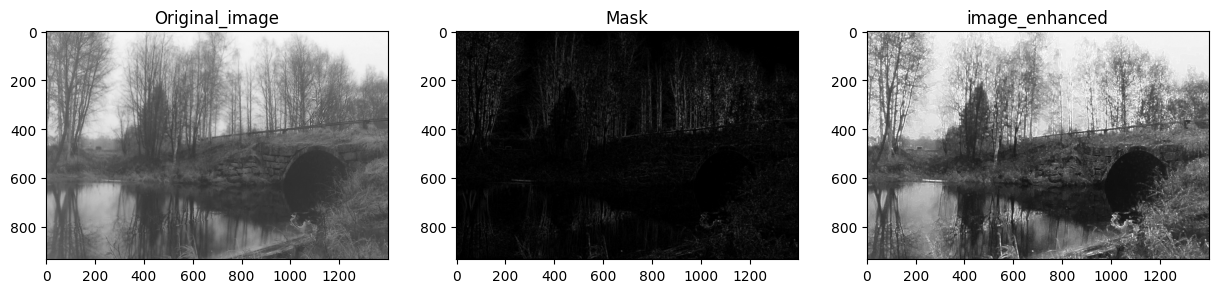

In [259]:
# Combine edges to create the mask

# Enhance the image
alpha = 2
mask = Image.fromarray(img_prewitt)
mask_enhanced = np.array(mask, dtype=np.float32) * alpha

img_enhanced = image_1_gray + mask_enhanced
img_enhanced = np.clip(img_enhanced, 0, 255).astype(np.uint8)  # Ensure valid pixel range

# plot images
fig = plt.figure(figsize=(15,10))

plt.subplot(1,3,1)
plt.imshow(image_1_gray, cmap = 'gray')
plt.title('Original_image')

plt.subplot(1,3,2)
plt.imshow(mask_enhanced, cmap = 'gray')
plt.title('Mask')

plt.subplot(1,3,3)
plt.imshow(img_enhanced, cmap = 'gray')
plt.title('image_enhanced')


3. Buscar una aplicación médica (en el libro de Gonzalez viene varios ejemplos de imágenes PET) y hacer mejoramiento usando la técnica de de la Figura 3.43 combinando diferentes etapas de procesamiento de imagenes

0. Cargar imagen

In [260]:
url = "https://www.mdpi.com/applsci/applsci-11-07858/article_deploy/html/images/applsci-11-07858-g005-550.jpg"
image_1 = load_image(url)

# convert image to numpy array
image_1 = np.array(image_1)

# convert image to grayscale w/o using opencv
r = image_1[:,:,0]
g = image_1[:,:,1]
b = image_1[:,:,2]

image_1_gray = 0.2989 * r + 0.5870 * g + 0.1140 * b
image_1_gray = image_1_gray.astype(float)

1. Aplicando filtro laplacino

Text(0.5, 1.0, 'image_enhanced with laplacian')

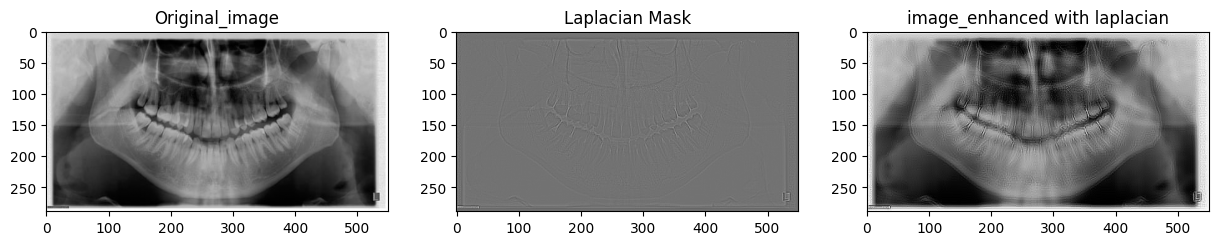

In [261]:
# Define Laplacian kernels (4,8 connected kernels)

laplacian_4_kernel = np.array([
                        [0, 1, 0],
                        [1, -4, 1],
                        [0, 1, 0]])
# apply filter
img_laplacian_4 =  apply_filter(image_1_gray, laplacian_4_kernel)

# Enhance the image
alpha = 2
mask = Image.fromarray(img_laplacian_4)
mask_enhanced = np.array(mask, dtype=np.float32) * alpha

img_enhanced = image_1_gray + mask_enhanced
img_enhanced = np.clip(img_enhanced, 0, 255).astype(np.uint8)  # Ensure valid pixel range

# plot images
fig = plt.figure(figsize=(15,10))

plt.subplot(1,3,1)
plt.imshow(image_1_gray, cmap = 'gray')
plt.title('Original_image')

plt.subplot(1,3,2)
plt.imshow(mask_enhanced, cmap = 'gray')
plt.title('Laplacian Mask')

plt.subplot(1,3,3)
plt.imshow(img_enhanced, cmap = 'gray')
plt.title('image_enhanced with laplacian')

2. Aplicando Sobel

Text(0.5, 1.0, 'image_enhanced with sobel')

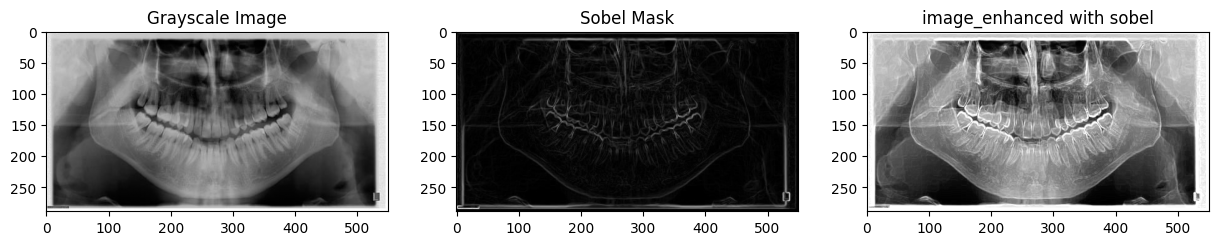

In [262]:
#define horizontal and Vertical sobel kernels
Gx = np.array([[-1, 0, 1],
               [-2, 0, 2],
               [-1, 0, 1]])

Gy = np.array([[-1, -2, -1],
               [0, 0, 0],
               [1, 2, 1]])

# apply filter
pre_x = apply_filter(image_1_gray, Gx)
pre_y = apply_filter(image_1_gray, Gy)

# compute gradiente magnitude
gradient_magnitude = np.sqrt(np.square(pre_x)+ np.square(pre_y))

# normalize
img_sobel = (gradient_magnitude /np.max(gradient_magnitude) * 255).astype(np.uint8)

# plot images
fig = plt.figure(figsize=(15,10))
plt.subplot(1,3,1)
plt.imshow(image_1_gray, cmap = 'gray')
plt.title('Grayscale Image')
plt.subplot(1,3,2)
plt.imshow(img_sobel, cmap = 'gray')
plt.title('Sobel Mask')

# Enhance the image
alpha = 2
mask = Image.fromarray(img_sobel)
mask_enhanced = np.array(mask, dtype=np.float32) * alpha

img_enhanced = image_1_gray + mask_enhanced
img_enhanced = np.clip(img_enhanced, 0, 255).astype(np.uint8)  # Ensure valid pixel range

plt.subplot(1,3,3)
plt.imshow(img_enhanced, cmap = 'gray')
plt.title('image_enhanced with sobel')



3. Aplicando Sobel Suavizado

Text(0.5, 1.0, 'image_enhanced with sobel - smooth 5x5 kernel')

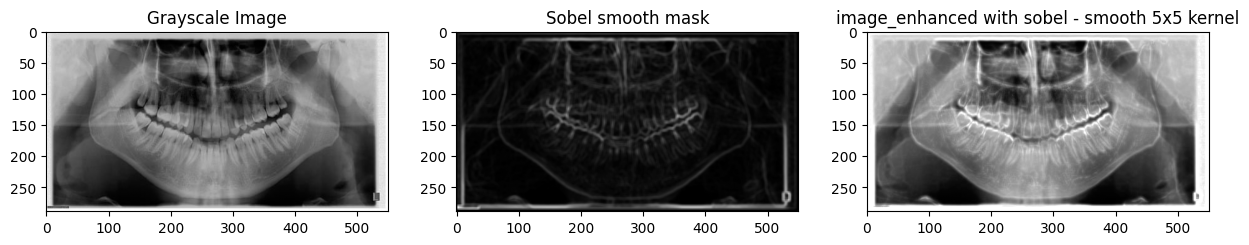

In [265]:
# Crear un kernel 5x5 para suavización

mean_kernel = np.ones((5, 5)) / 25
sobel_smooth =  apply_filter(img_sobel, mean_kernel)

# plot images
fig = plt.figure(figsize=(15,20))
plt.subplot(1,3,1)
plt.imshow(image_1_gray, cmap = 'gray')
plt.title('Grayscale Image')
plt.subplot(1,3,2)
plt.imshow(sobel_smooth, cmap = 'gray')
plt.title('Sobel smooth mask')

# Enhance the image
alpha = 2
mask = Image.fromarray(sobel_smooth)
mask_enhanced = np.array(mask, dtype=np.float32) * alpha

img_enhanced = image_1_gray + mask_enhanced
img_enhanced = np.clip(img_enhanced, 0, 255).astype(np.uint8)  # Ensure valid pixel range

plt.subplot(1,3,3)
plt.imshow(img_enhanced, cmap = 'gray')
plt.title('image_enhanced with sobel - smooth 5x5 kernel')
